In [9]:

import numpy as np
from tqdm import tqdm
from dungx.config import X_HATINH_PATH,Y_HATINH_PATH

In [10]:
def create_x_y_selected_features(list_path, selected_features=None):
    """
    Phiên bản tối ưu: Sửa lỗi index float, cố định thứ tự band và tăng tốc độ xử lý.
    """
    if selected_features is None:
        selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                             'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

    # 1) Đọc CSV và gộp
    dfs = []
    print("[B1] Đọc CSV...")
    for p in tqdm(list_path, desc="Đọc file CSV"):
        # Mẹo: Xác định dtype ngay lúc đọc để tiết kiệm bộ nhớ nếu file lớn
        df = pd.read_csv(p)
        df["variable"] = df["variable"].astype(str)
        # Gán nhãn y
        df.loc[df["variable"].isin(['2019', '2020']), "variable"] = 'y'
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True)

    # 2) Min/Max row/col → tạo hình chữ nhật
    min_row, max_row = df_all["row"].min(), df_all["row"].max()
    min_col, max_col = df_all["col"].min(), df_all["col"].max()
    n_row = int(max_row - min_row + 1)
    n_col = int(max_col - min_col + 1)

    # 3) Xác định danh sách band cần thiết (QUAN TRỌNG: Phải Sort để cố định thứ tự)
    required_bands_list = sorted(list(set(selected_features + ['y'])))
    required_bands_set = set(required_bands_list)
    print(f"-> Số lượng band bắt buộc: {len(required_bands_list)}")

    # 4) Lọc Timestamp hợp lệ (TỐI ƯU HÓA TỐC ĐỘ)
    print("[B2] Lọc timestamp đầy đủ (Vectorized Check)...")

    # Chỉ giữ lại các dòng thuộc các variable quan tâm để đếm cho nhanh
    df_check = df_all[df_all["variable"].isin(required_bands_set)]

    # Đếm số lượng variable unique trong mỗi timestamp
    # Nếu timestamp T1 có đủ 13 variable -> count sẽ là 13
    ts_counts = df_check.groupby("timestamp")["variable"].nunique()

    # Lấy ra các timestamp có số lượng variable bằng đúng số lượng yêu cầu
    valid_ts_index = ts_counts[ts_counts == len(required_bands_set)].index
    ts_valid = sorted(list(valid_ts_index))

    print(f"-> Tìm thấy {len(ts_valid)} timestamp hợp lệ.")

    # 5) Chuẩn bị dữ liệu để đổ vào Tensor
    print("[B3] Chuẩn bị index và Tensor...")

    # Tạo mapping index (Dictionary comprehension)
    t_to_idx = {t: i for i, t in enumerate(ts_valid)}
    b_to_idx = {b: i for i, b in enumerate(required_bands_list)} # Dùng list đã sort

    # Lọc dữ liệu chính thức:
    # - Chỉ lấy timestamp hợp lệ
    # - Chỉ lấy variable nằm trong required_bands (Bước này sửa lỗi Index Float)
    df_valid = df_all[
        (df_all["timestamp"].isin(ts_valid)) &
        (df_all["variable"].isin(required_bands_set))
    ].copy()

    # Map sang index (Ép kiểu int rõ ràng để tránh lỗi)
    df_valid["t_idx"] = df_valid["timestamp"].map(t_to_idx).astype(int)
    df_valid["b_idx"] = df_valid["variable"].map(b_to_idx).astype(int)
    df_valid["r_idx"] = (df_valid["row"] - min_row).astype(int)
    df_valid["c_idx"] = (df_valid["col"] - min_col).astype(int)

    # 6) Đổ dữ liệu vào Tensor (Vectorized - Không cần vòng lặp)
    print("[B4] Đổ dữ liệu vào Tensor...")
    # tensor = np.zeros((len(ts_valid), len(required_bands_list), n_row, n_col), dtype=float)

    tensor = np.full(
        (len(ts_valid), len(required_bands_list), n_row, n_col),
        -1,
        dtype=float
    )

    # Numpy Advanced Indexing: Nhanh hơn loop rất nhiều
    tensor[df_valid["t_idx"].values,
           df_valid["b_idx"].values,
           df_valid["r_idx"].values,
           df_valid["c_idx"].values] = df_valid["value"].values

    # 7) Tách X và y
    y_idx = b_to_idx['y']
    # Lấy mảng X indices: loại bỏ index của y
    x_indices = [i for i, b in enumerate(required_bands_list) if b != 'y']

    y = tensor[:, [y_idx], :, :]
    x = tensor[:, x_indices, :, :]

    return x, y, ts_valid, required_bands_list, (min_row, max_row), (min_col, max_col)

In [11]:
def luuTensor():
    list_file = [
        'csv_data/HIMA_hatinh.csv',
        'csv_data/ERA5_hatinh.csv',
        'csv_data/RADAR_hatinh.csv'
    ]

    x, y, timestamps, x_bands, row_range, col_range = create_x_y_selected_features(list_file)

    print("[B4] Lưu tensor...")
    np.save("csv_data/x_hatinh.npy", x)
    np.save('csv_data/y_hatinh.npy', np.squeeze(y, axis=1))

luuTensor()

[B1] Đọc CSV...


Đọc file CSV: 100%|██████████| 3/3 [00:16<00:00,  5.56s/it]


-> Số lượng band bắt buộc: 13
[B2] Lọc timestamp đầy đủ (Vectorized Check)...
-> Tìm thấy 1223 timestamp hợp lệ.
[B3] Chuẩn bị index và Tensor...
[B4] Đổ dữ liệu vào Tensor...
[B4] Lưu tensor...


In [12]:
xHaTinh = np.load(X_HATINH_PATH)
yHaTinh = np.load(Y_HATINH_PATH)
print('X đầy đủ',xHaTinh.shape)
print('y đầy đủ',yHaTinh.shape)

X đầy đủ (1223, 12, 21, 34)
y đầy đủ (1223, 21, 34)


In [13]:
# 2. Thống kê số lượng số 0
total_pixels = yHaTinh.size                  # Tổng số điểm dữ liệu (Time x Row x Col)
zero_pixels = np.sum(yHaTinh == 0)           # Số lượng điểm bằng 0 tuyệt đối
near_zero_pixels = np.sum(yHaTinh < 0.1)     # Số lượng điểm rất nhỏ (gần như 0)

percent_zeros = (zero_pixels / total_pixels) * 100

print(f"{'='*40}")
print(f"BÁO CÁO DỮ LIỆU Y (Mưa)")
print(f"{'='*40}")
print(f"1. Kích thước (Shape): {yHaTinh.shape}")
print(f"2. Tổng số pixel:      {total_pixels:,}")
print(f"3. Số lượng giá trị 0: {zero_pixels:,}")
print(f"4. Tỷ lệ số 0:         {percent_zeros:.2f}%")
print(f"5. Giá trị lớn nhất:   {yHaTinh.max()}")
print(f"6. Giá trị nhỏ nhất:   {yHaTinh.min()}")
print(f"{'='*40}")

BÁO CÁO DỮ LIỆU Y (Mưa)
1. Kích thước (Shape): (1223, 21, 34)
2. Tổng số pixel:      873,222
3. Số lượng giá trị 0: 323,122
4. Tỷ lệ số 0:         37.00%
5. Giá trị lớn nhất:   260.0
6. Giá trị nhỏ nhất:   -1.0


## chuẩn hóa dữ liệu numpy

In [34]:
from scipy.interpolate import griddata

def preprocess_data(data, data_type):
    if data is None:
        return None
    # Xử lý giá trị không hợp lệ bằng nội suy
    if np.any(np.isinf(data) | np.isnan(data) | (data == -9999)):
        mask = np.isinf(data) | np.isnan(data) | (data == -9999)
        x, y = np.indices(data.shape)
        valid_points = np.column_stack((x[~mask], y[~mask]))
        valid_values = data[~mask]
        invalid_points = np.column_stack((x[mask], y[mask]))
        if len(valid_values) > 0:
            interpolated_values = griddata(valid_points, valid_values, invalid_points, method='nearest')
            data[mask] = interpolated_values
        else:
            data[mask] = 0
    if data_type == "Radar":
        data = np.maximum(data, 0)  # Đảm bảo không có giá trị âm
    else:
        # Min-max scaling cho Himawari và ERA5
        data_min, data_max = np.min(data), np.max(data)
        if data_max > data_min:
            data = (data - data_min) / (data_max - data_min)
        else:
            data = np.zeros_like(data)
    return data

In [35]:
xHaTinh = preprocess_data(xHaTinh,'')
yHaTinh = preprocess_data(yHaTinh,'Radar')


In [36]:

# 2. Thống kê số lượng số 0
total_pixels = yHaTinh.size                  # Tổng số điểm dữ liệu (Time x Row x Col)
zero_pixels = np.sum(yHaTinh == 0)           # Số lượng điểm bằng 0 tuyệt đối
near_zero_pixels = np.sum(yHaTinh < 0.1)     # Số lượng điểm rất nhỏ (gần như 0)

percent_zeros = (zero_pixels / total_pixels) * 100

print(f"{'='*40}")
print(f"BÁO CÁO DỮ LIỆU Y (Mưa)")
print(f"{'='*40}")
print(f"1. Kích thước (Shape): {yHaTinh.shape}")
print(f"2. Tổng số pixel:      {total_pixels:,}")
print(f"3. Số lượng giá trị 0: {zero_pixels:,}")
print(f"4. Tỷ lệ số 0:         {percent_zeros:.2f}%")
print(f"5. Giá trị lớn nhất Y:   {yHaTinh.max()}")
print(f"6. Giá trị nhỏ nhất Y:   {yHaTinh.min()}")
print(f"5. Giá trị lớn nhất X:   {xHaTinh.max()}")
print(f"6. Giá trị nhỏ nhất X:   {xHaTinh.min()}")
print(f"{'='*40}")


BÁO CÁO DỮ LIỆU Y (Mưa)
1. Kích thước (Shape): (1223, 21, 34)
2. Tổng số pixel:      873,222
3. Số lượng giá trị 0: 803,761
4. Tỷ lệ số 0:         92.05%
5. Giá trị lớn nhất Y:   260.0
6. Giá trị nhỏ nhất Y:   0.0
5. Giá trị lớn nhất X:   1.0
6. Giá trị nhỏ nhất X:   0.0


In [37]:
np.save(X_HATINH_PATH,xHaTinh)
np.save(Y_HATINH_PATH,yHaTinh)

In [40]:
x_hatinh_new = np.load(X_HATINH_PATH)
y_hatinh_new = np.load(Y_HATINH_PATH)

In [41]:
print(f"5. Giá trị lớn nhất Y:   {yHaTinh.max()}")
print(f"6. Giá trị nhỏ nhất Y:   {yHaTinh.min()}")
print(f"5. Giá trị lớn nhất X:   {xHaTinh.max()}")
print(f"6. Giá trị nhỏ nhất X:   {xHaTinh.min()}")

5. Giá trị lớn nhất Y:   260.0
6. Giá trị nhỏ nhất Y:   0.0
5. Giá trị lớn nhất X:   1.0
6. Giá trị nhỏ nhất X:   0.0


Shape dùng để vẽ bản đồ: (21, 34)


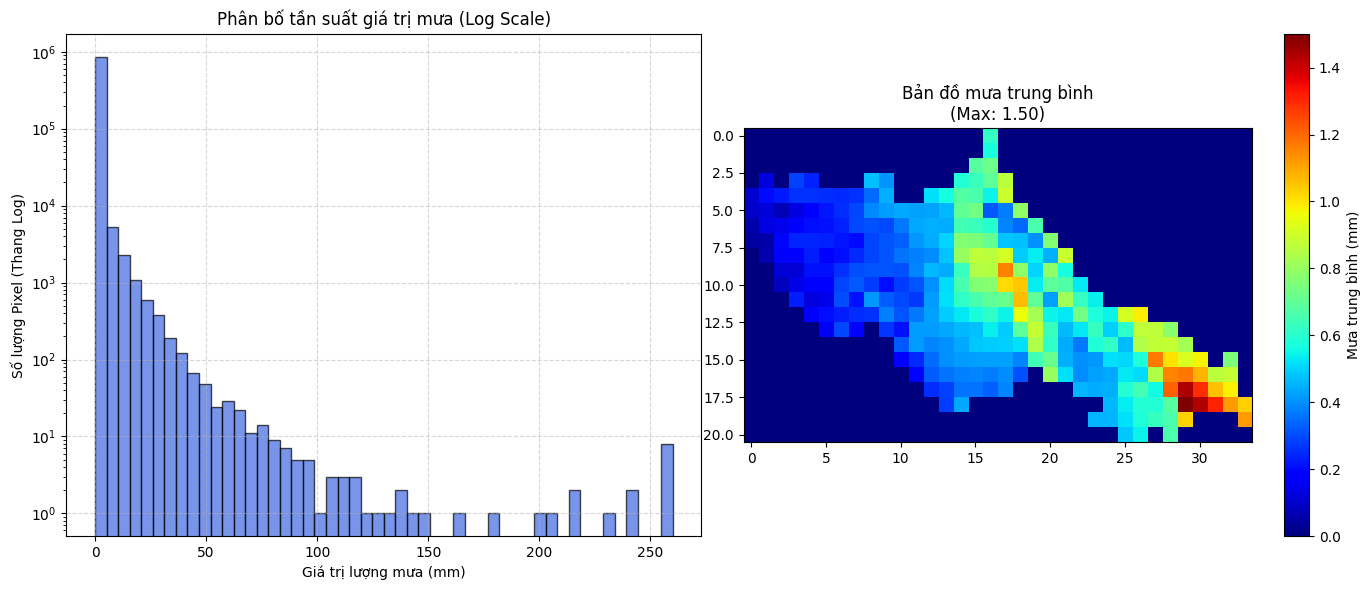

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn đã load yHaTinh rồi
# yHaTinh = np.load("csv_data/y_hatinh.npy")

# --- BƯỚC 1: TÍNH TOÁN VÀ XỬ LÝ SHAPE ---
# Tính trung bình theo thời gian (axis=0)
mean_rain = np.mean(yHaTinh, axis=0)

# QUAN TRỌNG: Dùng .squeeze() để loại bỏ các chiều có kích thước = 1
# Ví dụ: Biến shape (1, 21, 34) thành (21, 34) để imshow vẽ được
mean_rain = mean_rain.squeeze()

print(f"Shape dùng để vẽ bản đồ: {mean_rain.shape}")
# Nếu in ra (21, 34) là chuẩn. Nếu ra (1, 21, 34) là lỗi.

# --- BƯỚC 2: VẼ BIỂU ĐỒ ---
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Histogram (Phân bố giá trị)
plt.subplot(1, 2, 1)
# flatten() để duỗi thẳng dữ liệu ra đếm cho dễ
plt.hist(yHaTinh.flatten(), bins=50, log=True, color='royalblue', edgecolor='black', alpha=0.7)
plt.title("Phân bố tần suất giá trị mưa (Log Scale)")
plt.xlabel("Giá trị lượng mưa (mm)")
plt.ylabel("Số lượng Pixel (Thang Log)")
plt.grid(True, linestyle='--', alpha=0.5)

# Biểu đồ 2: Bản đồ nhiệt (Heatmap)
plt.subplot(1, 2, 2)
# cmap='jet' (xanh->đỏ) hoặc 'Blues' (trắng->xanh đậm) tùy bạn thích
im = plt.imshow(mean_rain, cmap='jet', interpolation='nearest')
plt.colorbar(im, label='Mưa trung bình (mm)')
plt.title(f"Bản đồ mưa trung bình\n(Max: {mean_rain.max():.2f})")

plt.tight_layout()
plt.show()

Shape: (1223, 21, 34)


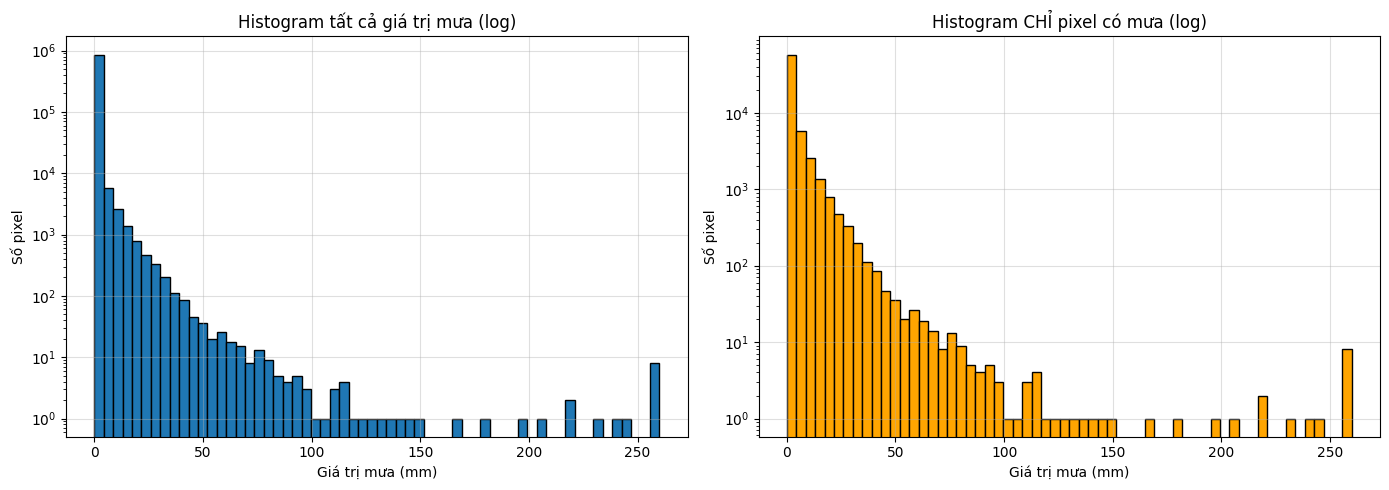

In [43]:
# --- Xử lý shape ---
y = yHaTinh.squeeze()      # -> (T, ROW, COL)
T, ROW, COL = y.shape
print("Shape:", y.shape)

# Mean theo time
mean_rain = np.mean(y, axis=0)

# Tổng mưa theo thời gian
sum_t = np.sum(y, axis=(1,2))

# Flatten tất cả giá trị
flat = y.flatten()
flat_nonzero = flat[flat > 0]
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.hist(flat, bins=60, log=True, edgecolor='black')
plt.title("Histogram tất cả giá trị mưa (log)")
plt.xlabel("Giá trị mưa (mm)")
plt.ylabel("Số pixel")
plt.grid(True, alpha=0.4)

plt.subplot(1,2,2)
plt.hist(flat_nonzero, bins=60, log=True, edgecolor='black', color='orange')
plt.title("Histogram CHỈ pixel có mưa (log)")
plt.xlabel("Giá trị mưa (mm)")
plt.ylabel("Số pixel")
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()


2. Heatmap mưa trung bình + Heatmap độ lệch chuẩn

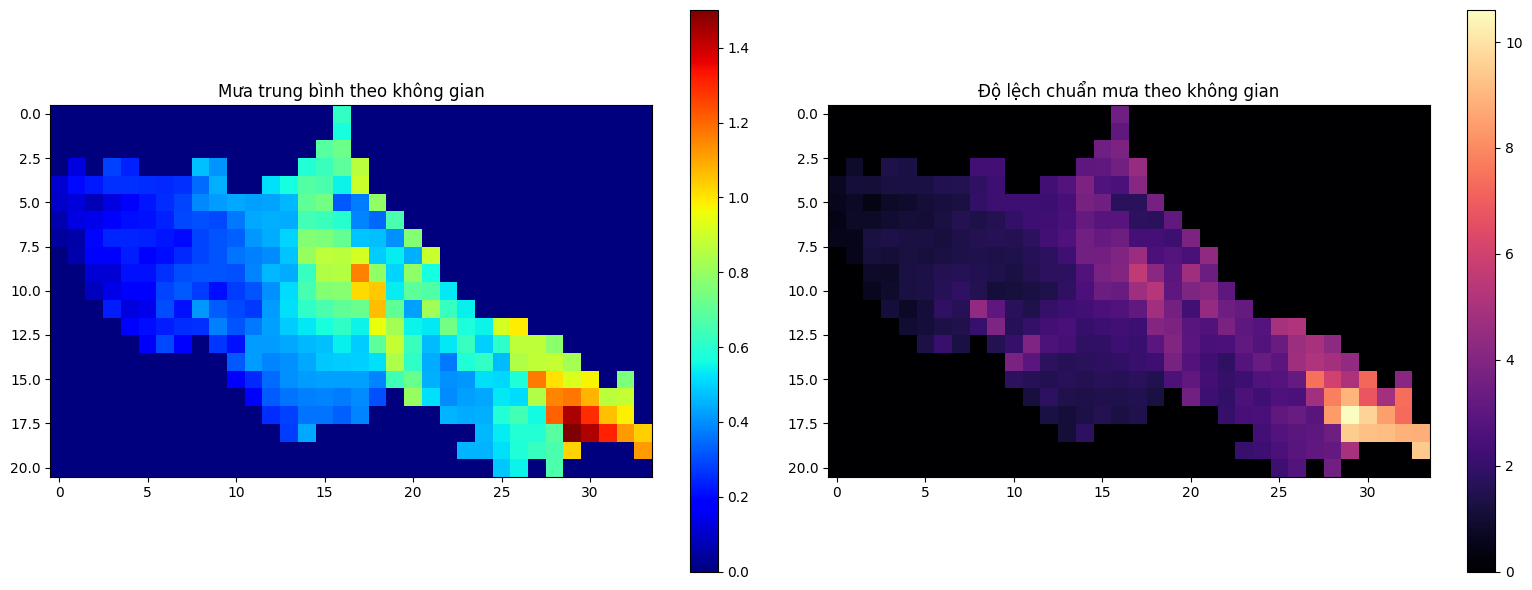

In [52]:
# ----------------------------------------------------------------------
# Tính độ lệch chuẩn (standard deviation) của lượng mưa theo TRỤC THỜI GIAN
# ----------------------------------------------------------------------
# std_rain = mức độ biến động của lượng mưa tại mỗi pixel
# Ý nghĩa trong bài toán dự đoán mưa:
#   • Pixel có std cao → mưa thay đổi thất thường → dự đoán khó hơn.
#   • Pixel std thấp  → mưa ổn định             → mô hình dễ học hơn.
# std giúp hiểu "tính bất định" của vùng mưa trong dữ liệu.
std_rain = np.std(y, axis=0)



plt.figure(figsize=(16,6))

# ----------------------------------------------------------------------
# HÌNH 1 – Mưa trung bình theo không gian
# mean_rain[row, col] = trung bình lượng mưa của pixel trong toàn bộ chuỗi thời gian
#
# TÁC DỤNG TRONG BÀI TOÁN MƯA:
#   • Cho biết khu vực nào có mưa nhiều / ít theo VĨNH CỮU.
#   • Giúp nhận diện vùng “nền mưa cao” so với vùng khô.
#   • Mô hình học tốt hơn vì biết được cấu trúc nền của trường mưa.
# ----------------------------------------------------------------------
plt.subplot(1,2,1)
im1 = plt.imshow(mean_rain, cmap='jet')
plt.title("Mưa trung bình theo không gian")
plt.colorbar(im1)



# ----------------------------------------------------------------------
# HÌNH 2 – Độ lệch chuẩn theo không gian (biến động mưa)
#
# TÁC DỤNG TRONG BÀI TOÁN MƯA:
#   • std_rain lớn: vùng có mưa dao động mạnh → khó dự đoán → mô hình cần chú ý.
#   • std_rain nhỏ: vùng ổn định → dễ dự đoán.
#   • Giúp hiểu được “độ nhiễu” của từng khu vực trong dữ liệu mưa.
#   • Tìm các vùng cực đoan (thường gây lũ quét).
# ----------------------------------------------------------------------
plt.subplot(1,2,2)
im2 = plt.imshow(std_rain, cmap='magma')
plt.title("Độ lệch chuẩn mưa theo không gian")
plt.colorbar(im2)



plt.tight_layout()
plt.show()


Biểu đồ tổng mưa theo thời gian (dùng để dự đoán mùa vụ)

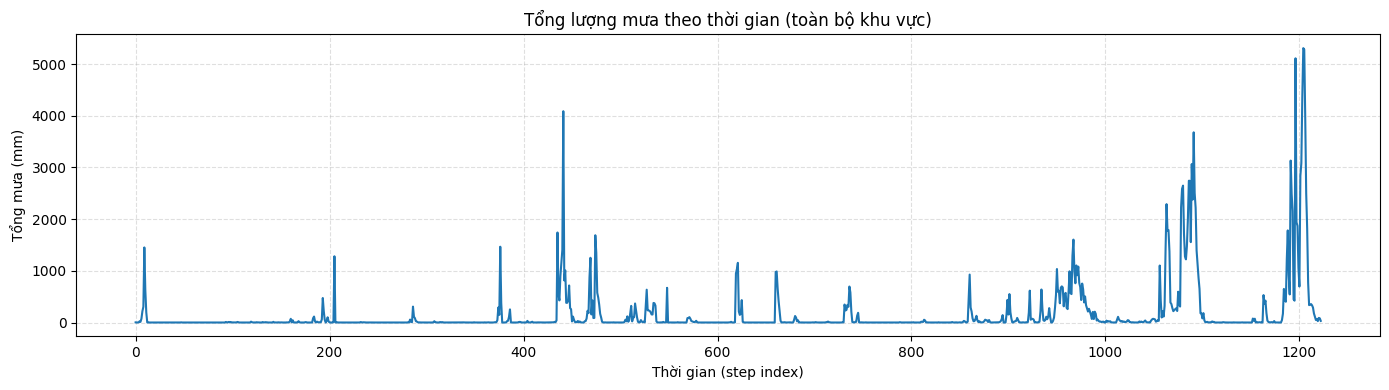

In [51]:
# -----------------------------------------------------------
# PHÂN TÍCH TỔNG LƯỢNG MƯA THEO THỜI GIAN (TIME SERIES)
#
# sum_t = tổng lượng mưa toàn tỉnh (hoặc toàn grid) tại mỗi timestamp
#        sum_t[t] = tổng lượng mưa của toàn bộ pixels ở thời điểm t
#
# Chức năng:
#   - Vẽ chuỗi thời gian của tổng mưa → xem các đợt mưa lớn (rain events)
#   - Giúp phát hiện mùa mưa – mùa khô
#   - Nhìn rõ các peak mưa cực lớn (bão, áp thấp, không khí lạnh)
#
# Tác dụng đối với mô hình dự đoán mưa:
#   1) Giúp phát hiện outliers:
#         - ngày mưa cực lớn → cần normalization đặc biệt
#
#   2) Giúp hiểu cấu trúc thời gian:
#         - nếu mưa mang tính chu kỳ → mô hình RNN/CNN-LSTM học tốt
#
#   3) Xác định độ biến động theo thời gian:
#         - chuỗi rất nhiễu → cần smoothing, rolling mean
#
#   4) Phát hiện gaps trong dữ liệu → timestamp mất band
#
#   5) Đánh giá phân phối tổng mưa:
#         - mưa tập trung vào một vài ngày → mô hình học khó
#         - mưa phân bố đều → mô hình dễ học
# -----------------------------------------------------------

plt.figure(figsize=(14, 4))
plt.plot(sum_t, linewidth=1.5)
plt.title("Tổng lượng mưa theo thời gian (toàn bộ khu vực)")
plt.xlabel("Thời gian (step index)")
plt.ylabel("Tổng mưa (mm)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Lấy 1 ngày và plot ra

Shape ngày: (21, 34)


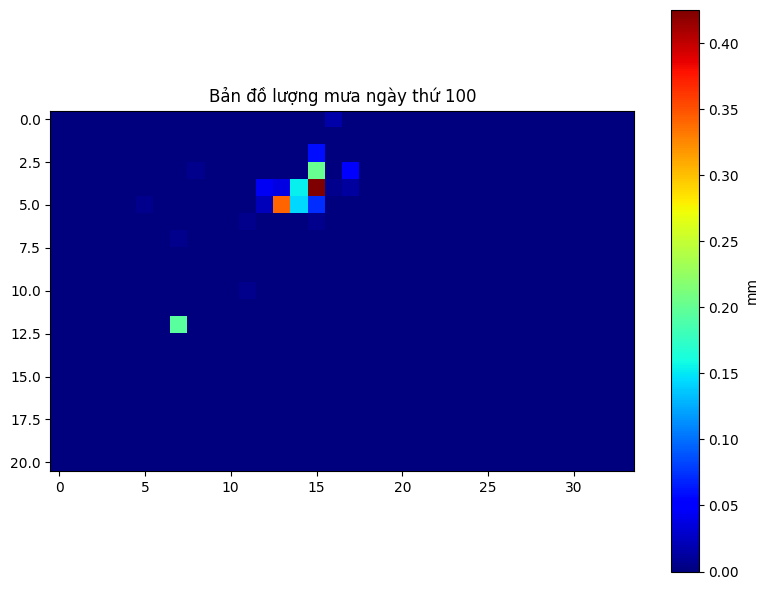

In [46]:

# --- CHỌN NGÀY ---
day = 100   # ví dụ chọn ngày thứ 100, có thể thay số khác
one_day = y[day]   # shape (ROW, COL)

print("Shape ngày:", one_day.shape)

# --- VẼ ---
plt.figure(figsize=(8, 6))
im = plt.imshow(one_day, cmap='jet')
plt.colorbar(im, label='mm')
plt.title(f"Bản đồ lượng mưa ngày thứ {day}")
plt.tight_layout()
plt.show()

✅ 6. Bản đồ vùng khô – vùng ẩm (Binary Map)

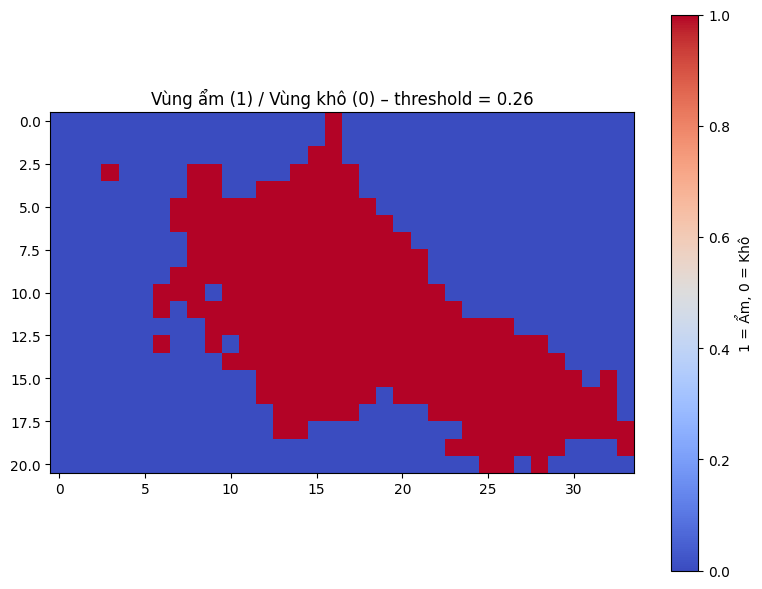

In [50]:
# -----------------------------------------------------------
# PHÂN LOẠI VÙNG ẨM / VÙNG KHÔ TRÊN BẢN ĐỒ MƯA TRUNG BÌNH
#
# Chức năng:
#   - Dùng phân vị (percentile) để tìm ngưỡng (threshold)
#     tách bản đồ mưa trung bình thành 2 vùng:
#         1 = vùng ẩm (mưa nhiều)
#         0 = vùng khô (mưa ít)
#
# Tại sao phải làm?
#   ➜ Đây là bước phân tích không gian rất quan trọng:
#       • Giúp hiểu vị trí nào thường xuyên có mưa
#       • Phát hiện vùng “mưa cố định” (rain hotspot)
#       • Phát hiện vùng “khô cố định” (dry zone)
#       • Giúp model học trọng số không gian tốt hơn
#
# Tác dụng trong bài toán dự đoán mưa:
#   1) Xác định các khu vực mưa cao → mô hình cần quan tâm nhiều hơn
#   2) Giúp đánh giá độ lệch dữ liệu (spatial imbalance)
#   3) Xác định xem mô hình cần "spatial attention" nhiều hay không
#   4) Giúp hiểu mưa ở Hà Tĩnh tập trung ở khu vực nào:
#         - thường là phía núi (địa hình tạo mưa)
#         - hoặc phía ven biển (gió mùa đông bắc)
#
#   => Rất hữu ích để thiết kế cấu trúc CNN/ConvLSTM phù hợp.
# -----------------------------------------------------------

# 1) Lấy toàn bộ giá trị mưa (loại bỏ 0 vì là nền)
flat_nonzero = mean_rain[mean_rain > 0].flatten()

# 2) Chọn ngưỡng percentile 20% (có thể đổi thành 30, 40, 50...)
threshold = np.percentile(flat_nonzero, 20)

# 3) Tạo bản đồ nhị phân (binary map):
#     > threshold  →  vùng ẩm (1)
#     <= threshold →  vùng khô (0)
dry_wet = (mean_rain > threshold).astype(int)

# 4) Vẽ heatmap
plt.figure(figsize=(8, 6))
plt.imshow(dry_wet, cmap='coolwarm')  # đỏ = ẩm, xanh = khô
plt.title(f"Vùng ẩm (1) / Vùng khô (0) – threshold = {threshold:.2f}")
plt.colorbar(label="1 = Ẩm, 0 = Khô")
plt.tight_layout()
plt.show()


7. Biểu đồ “Spatial Correlation Map” – mức độ tương quan giữa các vị trí

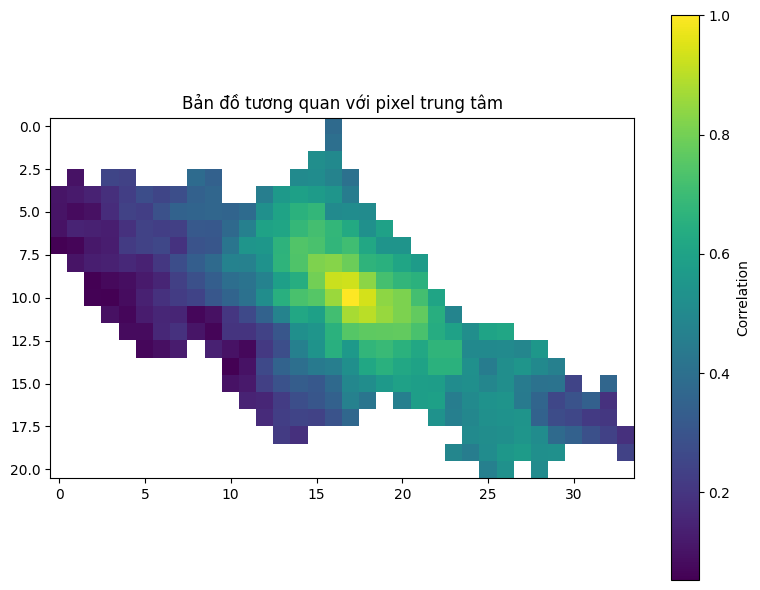

In [49]:
# -----------------------------------------------------------
# BẢN ĐỒ TƯƠNG QUAN (Correlation Map)
#
# Mục đích:
#   - Đo mức độ liên hệ (tương quan) giữa pixel trung tâm và
#     toàn bộ các pixel khác trong vùng không gian.
#   - Dùng để hiểu cấu trúc phụ thuộc không gian của lượng mưa.
#
# Ý nghĩa đối với bài toán dự đoán mưa (Rainfall Forecasting):
#   1) Giúp xem mưa tại một vị trí có bị ảnh hưởng bởi vùng xung quanh hay không.
#      → Nếu tương quan cao → mưa có tính lan truyền không gian (spatial dependency).
#
#   2) Cho thấy mô hình ML/CNN/LSTM cần học bao nhiêu "spatial context".
#      → Nếu tương quan lan rộng → mô hình cần receptive field lớn.
#      → Nếu chỉ vùng nhỏ có tương quan → patch nhỏ là đủ.
#
#   3) Xác định các vùng cùng biến động (coherent rainfall patterns).
#      → Hữu ích cho thiết kế feature, attention, và mô hình spatiotemporal.
#
#   4) Phát hiện noise hoặc cảm biến lỗi.
#      → Pixel không tương quan với ai → khả năng dữ liệu lỗi.
#
#   5) Giúp đánh giá độ ổn định của dữ liệu theo không gian.
#      → Quan trọng để hiểu tại sao model dự đoán tốt hoặc kém.
#
# Tóm lại:
#   Bản đồ tương quan giúp bạn hiểu "cấu trúc không gian" của lượng mưa,
#   từ đó tinh chỉnh mô hình dự đoán mưa để chính xác hơn.
# -----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# y có shape (T, ROW, COL)
T, ROW, COL = y.shape

# 1) Time-series của pixel trung tâm
center_pixel = y[:, ROW // 2, COL // 2]

# 2) Ma trận lưu tương quan với mỗi pixel
corr_map = np.zeros((ROW, COL))

# 3) Tính tương quan
for i in range(ROW):
    for j in range(COL):
        corr_map[i, j] = np.corrcoef(center_pixel, y[:, i, j])[0, 1]

# 4) Vẽ heatmap tương quan
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_map, cmap='viridis')
plt.colorbar(im, label="Correlation")
plt.title("Bản đồ tương quan với pixel trung tâm")
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# Load dữ liệu
y_hatinh_new = np.load('csv_data/y_hatinh.npy')

# Kiểm tra số chiều
print(f"Số chiều của mảng: {y_hatinh_new.ndim}")
print(f"Shape của mảng: {y_hatinh_new.shape}")

# Nếu mảng có nhiều hơn 2 chiều, bạn có thể reshape hoặc lấy slice
if y_hatinh_new.ndim > 2:
    print("Mảng có nhiều hơn 2 chiều, có thể cần reshape:")
    print(f"Shape hiện tại: {y_hatinh_new.shape}")

    # Tùy chọn 1: Reshape về 2D
    # y_hatinh_new = y_hatinh_new.reshape(-1, y_hatinh_new.shape[-1])

    # Tùy chọn 2: Lấy slice đầu tiên
    # y_hatinh_new = y_hatinh_new[0]  # Lấy phần tử đầu tiên của chiều đầu tiên

# CÁCH IN MẢNG 2D:

# 1. In toàn bộ mảng (cẩn thận với mảng lớn)
print("\n=== Toàn bộ mảng ===")
print(y_hatinh_new)

# 2. In với format đẹp hơn
print("\n=== Mảng với precision cố định ===")
np.set_printoptions(precision=4, suppress=True, linewidth=100)
print(y_hatinh_new)

# 3. In một phần của mảng (nếu mảng quá lớn)
print("\n=== In phần đầu của mảng ===")
print("5 dòng đầu, 5 cột đầu:")
print(y_hatinh_new[:5, :5])

print("\n=== In phần cuối của mảng ===")
print("5 dòng cuối, 5 cột cuối:")
print(y_hatinh_new[-5:, -5:])

# 4. In với thông tin chi tiết
print("\n=== Thông tin chi tiết ===")
print(f"Kích thước: {y_hatinh_new.shape[0]} x {y_hatinh_new.shape[1]}")
print(f"Tổng số phần tử: {y_hatinh_new.size}")
print(f"Kiểu dữ liệu: {y_hatinh_new.dtype}")

# 5. In từng dòng với chỉ số
print("\n=== In từng dòng có đánh số ===")
for i in range(min(10, y_hatinh_new.shape[0])):  # Chỉ in 10 dòng đầu
    print(f"Dòng {i:3d}: {y_hatinh_new[i]}")

# 6. In dưới dạng bảng (cho mảng nhỏ)
print("\n=== Dạng bảng ===")
for i in range(min(5, y_hatinh_new.shape[0])):
    row_str = " | ".join([f"{val:8.4f}" for val in y_hatinh_new[i, :5]])
    print(f"{i:3d}: [{row_str}]")

# 7. Tạo DataFrame để in đẹp hơn (nếu có pandas)
try:
    import pandas as pd
    print("\n=== Dạng DataFrame (dễ đọc hơn) ===")
    df = pd.DataFrame(y_hatinh_new)

    # Chỉ hiển thị một phần nếu mảng lớn
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.width', 100)

    print(df)
except ImportError:
    print("\nCài đặt pandas để hiển thị dạng bảng đẹp hơn: pip install pandas")

# 8. Lưu ra file text để xem toàn bộ
print("\n=== Lưu ra file text ===")
np.savetxt('y_hatinh_new.txt', y_hatinh_new, fmt='%.6f', delimiter='\t')
print("Đã lưu toàn bộ mảng vào file: y_hatinh_new.txt")

# 9. In với các tùy chọn display
print("\n=== Với tùy chọn display đầy đủ ===")
np.set_printoptions(
    precision=4,        # Số chữ số thập phân
    suppress=True,      # Không hiển thị dưới dạng scientific notation
    threshold=100,      # Số phần tử tối đa trước khi bị truncate
    edgeitems=3,        # Số phần tử ở rìa khi bị truncate
    linewidth=120       # Độ rộng dòng
)
print(y_hatinh_new)

Số chiều của mảng: 3
Shape của mảng: (1223, 21, 34)
Mảng có nhiều hơn 2 chiều, có thể cần reshape:
Shape hiện tại: (1223, 21, 34)

=== Toàn bộ mảng ===
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 

TypeError: unsupported format string passed to numpy.ndarray.__format__